# Back-Test of 3M vol Swap (Start from 2010)
Vol Swap 3M, payoff = RV(3M) - IV(3M)

Rebalance every week (5 trading days)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load Data

In [2]:
directory = "h:/test_2005/"

trading_dates = pd.read_csv(directory + "trading_dates.csv", index_col=0)
trading_dates["MarketDate"] = pd.to_datetime(trading_dates["MarketDate"])

data = pd.read_csv(directory+"rolling_universe.csv", index_col=0)["Infocode"]
data.index = pd.to_datetime(data.index)
rolling_universe = {}
for key in data.index:
    rolling_universe[key] = np.array(data[key].split()).astype('int')
    
infocode_dict = pd.read_csv(directory + "infocode_dict.csv", index_col=0)["Ticker"].to_dict()

ticker_dict = pd.read_csv(directory + "ticker_dict.csv", index_col=0)["Infocode"].to_dict()

In [3]:
def read_stock_data(directory, name):
    stock_data = pd.read_csv(directory + name, index_col=0)
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data.columns = stock_data.columns.astype("int")
    return stock_data

In [4]:
stock_prices = read_stock_data(directory, 'stock_prices.csv')
stock_iv3m = read_stock_data(directory, 'stock_iv3m.csv')
stock_iv6m = read_stock_data(directory, 'stock_iv6m.csv')
stock_iv12m = read_stock_data(directory, 'stock_iv12m.csv')
stock_iv2m = read_stock_data(directory, 'stock_iv2m.csv')
stock_iv1m = read_stock_data(directory, 'stock_iv1m.csv')
stock_iv1m50delta = read_stock_data(directory, 'stock_iv1m50delta.csv')
stock_iv1m25delta = read_stock_data(directory, 'stock_iv1m25delta.csv')
stock_iv1m75delta = read_stock_data(directory, 'stock_iv1m75delta.csv')
stock_iv2m50delta = read_stock_data(directory, 'stock_iv2m50delta.csv')
stock_iv2m25delta = read_stock_data(directory, 'stock_iv2m25delta.csv')
stock_iv2m75delta = read_stock_data(directory, 'stock_iv2m75delta.csv')

In [5]:
stock_asset_per_equity = read_stock_data(directory, 'stock_asset_per_equity.csv')
stock_asset_per_marketcap = read_stock_data(directory, 'stock_asset_per_marketcap.csv')
stock_eps = read_stock_data(directory, 'stock_eps.csv')
stock_roe = read_stock_data(directory, 'stock_roe.csv')
stock_cps = read_stock_data(directory, 'stock_cps.csv')
stock_cpx_per_marketcap = read_stock_data(directory, 'stock_cpx_per_marketcap.csv')
stock_dps = read_stock_data(directory, 'stock_dps.csv')

In [6]:
trading_interval = 5
holding_period = 63

start_date = pd.to_datetime('20100101')
end_date = trading_dates["MarketDate"].iloc[-1]

rebalance_dates = []
valid_dates = trading_dates[(trading_dates["MarketDate"] >= start_date) & (trading_dates["MarketDate"] <= end_date)]
for i in range(0, len(valid_dates), trading_interval):
    rebalance_dates.append(valid_dates["MarketDate"].iloc[i])
    
trading_dates = list(pd.to_datetime(trading_dates["MarketDate"].values))

In [7]:
stock_returns = np.log(stock_prices/stock_prices.shift())

In [8]:
stock_rv1m = pd.rolling_std(stock_returns, 21) * np.sqrt(252)
stock_rv2m = pd.rolling_std(stock_returns, 42) * np.sqrt(252)
stock_rv3m = pd.rolling_std(stock_returns, 63) * np.sqrt(252)
stock_rv6m = pd.rolling_std(stock_returns, 126) * np.sqrt(252)
stock_rv12m = pd.rolling_std(stock_returns, 252) * np.sqrt(252)
stock_rv10d = pd.rolling_std(stock_returns, 10) * np.sqrt(252)

In [9]:
def get_z_score(stock_data):
    stock_data[stock_data == np.inf] = np.nan
    z_score = stock_data.sub(stock_data.mean(axis=1),axis=0).div(stock_data.std(axis=1),axis=0)
    z_score.dropna(how='all', axis=0, inplace=True)
    z_score.dropna(how='all', axis=1, inplace=True)
    z_score.fillna(0, inplace=True)
    return z_score

# Back Test Result

In [10]:
def backtest3m(score):
    daily_pnl = pd.Series(np.zeros(len(trading_dates)), index=trading_dates)
    for i in range(len(trading_dates)):
        date = trading_dates[i]
        #print date
        if (date in rebalance_dates) & (i + holding_period < len(trading_dates)):
            z = score.loc[date][rolling_universe[date]].dropna()
            z = (z-z.mean()) / z.std()
            z.sort(ascending=False)
            long_short = np.append(z.index[ : 1*len(z)/10], z.index[-(1*len(z)/10) : ])
            for infocode in long_short:
                if not np.isnan(stock_iv3m[infocode][date]):
                    daily_pnl[trading_dates[i+holding_period]] += np.sign(z[infocode]) * (stock_rv3m[infocode][trading_dates[i+holding_period]] - stock_iv3m[infocode][date])
    return daily_pnl


In [11]:
def sharpe_ratio(pnl):
    return pnl[pnl != 0].mean() / pnl[pnl != 0].std() * np.sqrt(12/3)

def pnl_mean(pnl):
    return pnl[pnl != 0].mean()

def pnl_std(pnl):
    return pnl[pnl != 0].std()

def hit_rate(pnl):
    return float(len(pnl[pnl > 0])) / len(pnl[pnl != 0])

def pnl_min(pnl):
    return pnl[pnl != 0].min()

def pnl_25perc(pnl):
    return pnl[pnl != 0].quantile(0.25)

def pnl_median(pnl):
    return pnl[pnl != 0].median()

def pnl_75perc(pnl):
    return pnl[pnl != 0].quantile(0.75)

def pnl_max(pnl):
    return pnl[pnl != 0].max()

In [12]:
def report_table(pnls, labels):
    result = pd.DataFrame(index = labels, columns=['Sharpe Ratio', 'PnL Mean', 'PnL Std', 'Hit Rate', 'PnL Min', 'PnL 25%Perc', 'PnL Median', 'PnL 75%Perc', 'PnL Max'])
    for i in range(len(pnls)):
        result.loc[labels[i]]['Sharpe Ratio'] = sharpe_ratio(pnls[i])
        result.loc[labels[i]]['PnL Mean'] = pnl_mean(pnls[i])
        result.loc[labels[i]]['PnL Std'] = pnl_std(pnls[i])
        result.loc[labels[i]]['Hit Rate'] = hit_rate(pnls[i])
        result.loc[labels[i]]['PnL Min'] = pnl_min(pnls[i])
        result.loc[labels[i]]['PnL 25%Perc'] = pnl_25perc(pnls[i])
        result.loc[labels[i]]['PnL Median'] = pnl_median(pnls[i])
        result.loc[labels[i]]['PnL 75%Perc'] = pnl_75perc(pnls[i])
        result.loc[labels[i]]['PnL Max'] = pnl_max(pnls[i])
    return result

In [13]:
def annual_pnl_mean(pnls, labels):
    years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
    result = pd.DataFrame(index = labels, columns=years)
    for i in range(len(pnls)):
        for year in years:
            result.loc[labels[i]][year] = pnl_mean(pnls[i][pd.to_datetime(year+'0101') : pd.to_datetime(year+'1231')])
    return result

## RV-IV

In [14]:
pnl1 = backtest3m(stock_rv6m - stock_iv3m)
pnl2 = backtest3m(stock_rv3m - stock_iv3m)
pnl3 = backtest3m(stock_rv2m - stock_iv3m)
pnl4 = backtest3m(stock_rv1m - stock_iv3m)
pnl5 = backtest3m(stock_rv10d - stock_iv3m)

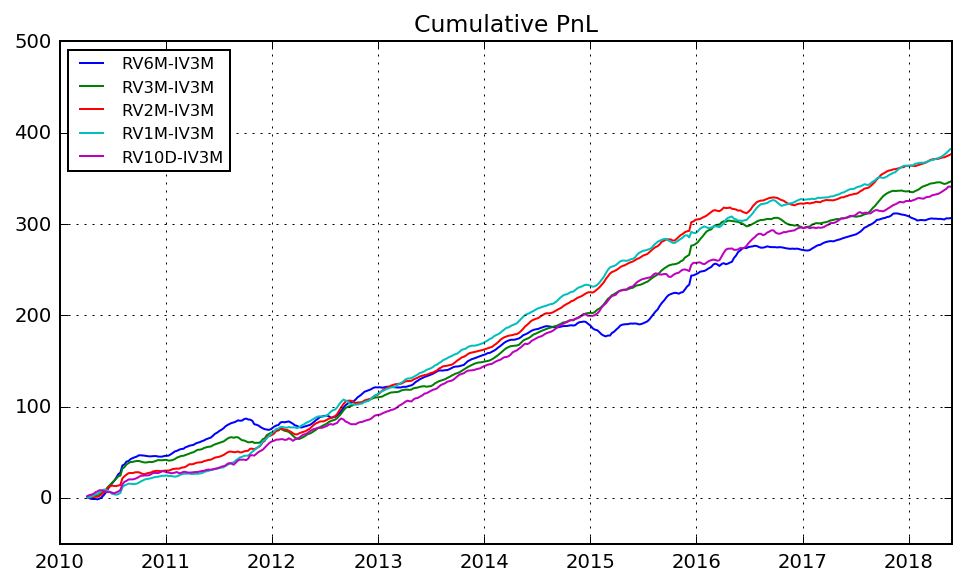

In [15]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV6M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV3M-IV3M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV2M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='RV1M-IV3M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='RV10D-IV3M')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [16]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
RV6M-IV3M,1.17027,0.74553,1.27412,0.754258,-3.76454,0.00961927,0.690549,1.30797,9.95999
RV3M-IV3M,1.49711,0.842913,1.12605,0.832117,-2.29783,0.284637,0.816013,1.33447,9.97035
RV2M-IV3M,1.66761,0.915221,1.09765,0.844282,-1.66818,0.293725,0.905178,1.43119,9.393
RV1M-IV3M,1.72039,0.929576,1.08066,0.851582,-2.49208,0.333172,0.915059,1.51923,6.24981
RV10D-IV3M,1.53371,0.829375,1.08153,0.810219,-2.628,0.199367,0.84069,1.46189,6.69574


In [17]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
RV6M-IV3M,1.21136,0.578181,0.911013,0.705542,0.691341,1.05664,0.542464,0.752608
RV3M-IV3M,1.09538,0.585351,0.773085,0.775223,1.07041,1.48504,0.373942,0.777052
RV2M-IV3M,0.786639,0.758106,0.889829,0.979537,1.26094,1.5593,0.358945,0.821641
RV1M-IV3M,0.638795,0.898831,0.87113,1.11524,1.27767,1.1147,0.745364,0.728684
RV10D-IV3M,0.763065,0.639267,0.587099,1.05348,1.12015,1.13286,0.777094,0.577637


## Momentum
Momentum of vol swap payoff during the last x days.

In [18]:
past_payoff = stock_rv3m - stock_iv3m.shift(63)

In [19]:
pnl1 = backtest3m(pd.rolling_mean(past_payoff, 1))
pnl2 = backtest3m(pd.rolling_mean(past_payoff, 5))
pnl3 = backtest3m(pd.rolling_mean(past_payoff, 10))
pnl4 = backtest3m(pd.rolling_mean(past_payoff, 21))
pnl5 = backtest3m(pd.rolling_mean(past_payoff, 63))

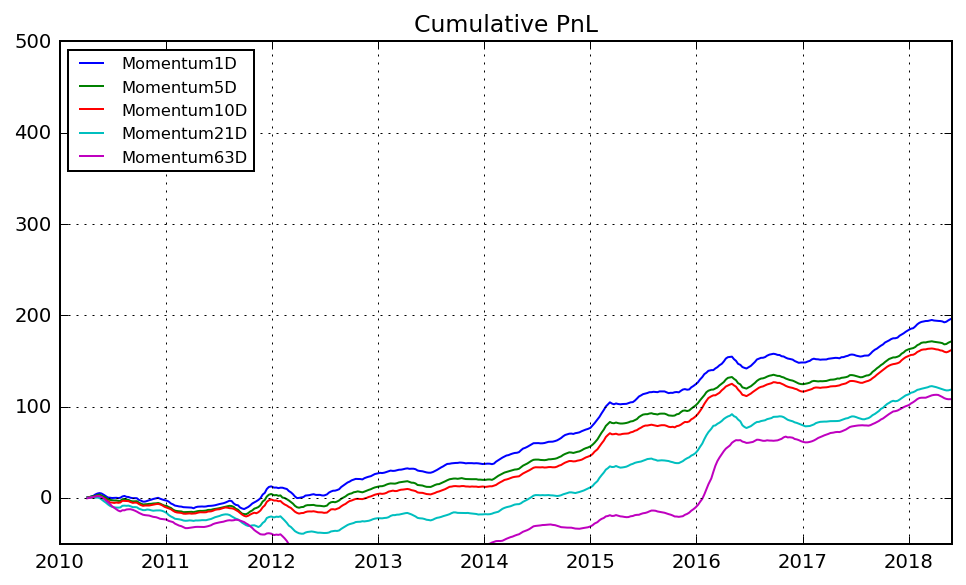

In [20]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Momentum1D')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Momentum5D')
plt.plot(pnl3[pnl3!=0].cumsum(), label='Momentum10D')
plt.plot(pnl4[pnl4!=0].cumsum(), label='Momentum21D')
plt.plot(pnl5[pnl5!=0].cumsum(), label='Momentum63D')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [21]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
RV6M-IV3M,0.849964,0.47631,1.12078,0.688564,-3.21762,-0.184457,0.452826,1.15833,4.23762
RV3M-IV3M,0.758626,0.416132,1.09707,0.671533,-3.17018,-0.258557,0.387997,1.07603,4.12624
RV2M-IV3M,0.724837,0.392883,1.08406,0.6618,-3.14742,-0.25468,0.376422,1.01124,4.00867
RV1M-IV3M,0.501036,0.288099,1.15001,0.627737,-4.22501,-0.335553,0.260788,0.912687,4.78173
RV10D-IV3M,0.411203,0.263196,1.28013,0.605839,-3.99969,-0.382953,0.207501,0.855748,7.17148


In [22]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
RV6M-IV3M,-0.0640597,0.296387,0.284345,0.205195,0.767808,0.958956,0.477469,0.672798
RV3M-IV3M,-0.221708,0.250258,0.159179,0.150395,0.707638,0.904688,0.467237,0.733665
RV2M-IV3M,-0.254345,0.157731,0.119365,0.163437,0.652632,0.867086,0.54669,0.748288
RV1M-IV3M,-0.399373,-0.100632,-0.0372569,0.0833448,0.563881,0.765158,0.622173,0.639761
RV10D-IV3M,-0.620132,-0.304791,-0.40061,0.164631,0.375299,0.427716,1.44942,0.765865


## Low-Risk
Momentum of vol swap payoff during the last x days.

In [23]:
past_payoff = stock_rv3m - stock_iv3m.shift(63)

In [24]:
pnl1 = backtest3m(-pd.rolling_var(past_payoff, 5))
pnl2 = backtest3m(-pd.rolling_var(past_payoff, 10))
pnl3 = backtest3m(-pd.rolling_var(past_payoff, 21))
pnl4 = backtest3m(-pd.rolling_var(past_payoff, 63))
pnl5 = backtest3m(-pd.rolling_var(past_payoff, 126))

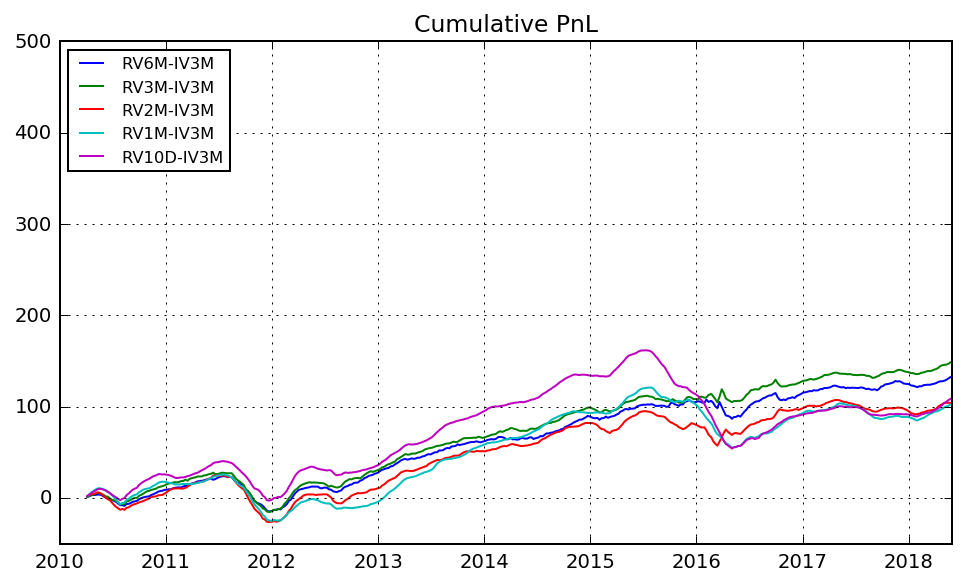

In [25]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV6M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV3M-IV3M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV2M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='RV1M-IV3M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='RV10D-IV3M')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [26]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
RV6M-IV3M,0.481269,0.322054,1.33835,0.666667,-5.40098,-0.309377,0.461697,1.05851,6.81358
RV3M-IV3M,0.524379,0.361005,1.37688,0.666667,-5.6974,-0.206743,0.495319,1.04986,8.43505
RV2M-IV3M,0.353616,0.253347,1.43289,0.644769,-4.63013,-0.395895,0.338413,1.06451,4.95374
RV1M-IV3M,0.353454,0.248438,1.40577,0.659367,-4.80459,-0.466694,0.492325,1.15136,3.11853
RV10D-IV3M,0.33701,0.263753,1.56525,0.683698,-5.11976,-0.375456,0.564652,1.23958,4.4569


In [27]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
RV6M-IV3M,0.231849,-0.456723,0.839069,0.684024,0.564935,0.294122,0.179946,0.220925
RV3M-IV3M,0.360395,-0.558046,0.904959,0.704818,0.662342,0.186003,0.377837,0.221243
RV2M-IV3M,0.125667,-0.606017,0.734483,0.812251,0.617775,-0.0368024,0.346371,-0.0129663
RV1M-IV3M,0.46639,-0.840091,0.413593,1.24499,0.705202,0.185103,-0.20926,-0.0632234
RV10D-IV3M,0.679474,-0.550325,0.760695,1.16899,0.804028,-0.409691,-0.4528,0.017017


## RV-past IV

In [28]:
pnl1 = backtest3m(stock_rv6m - stock_iv3m.shift(63))
pnl2 = backtest3m(stock_rv3m - stock_iv3m.shift(63))
pnl3 = backtest3m(stock_rv2m - stock_iv3m.shift(63))
pnl4 = backtest3m(stock_rv1m - stock_iv3m.shift(63))
pnl5 = backtest3m(stock_rv10d - stock_iv3m.shift(63))

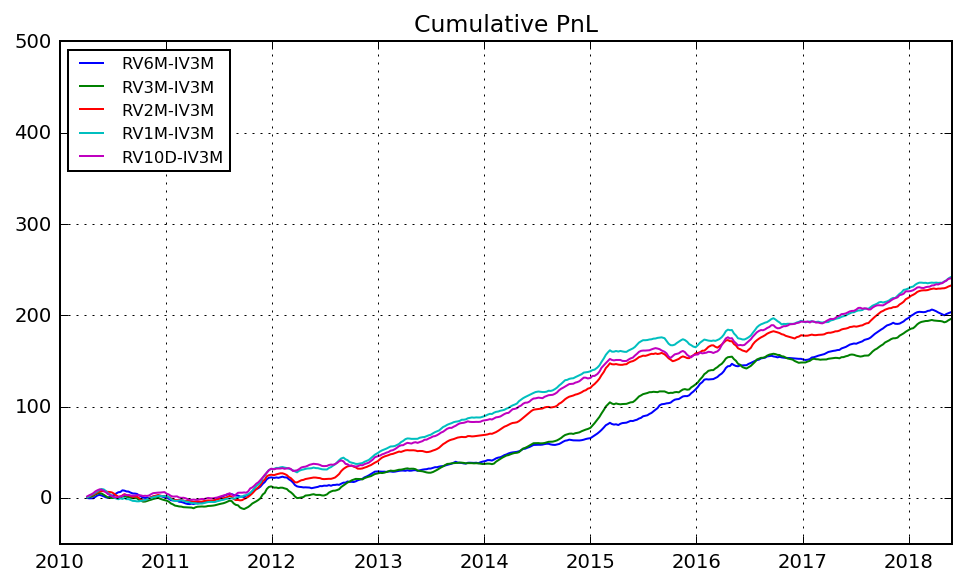

In [29]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV6M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV3M-IV3M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV2M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='RV1M-IV3M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='RV10D-IV3M')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [30]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
RV6M-IV3M,1.06812,0.494373,0.925692,0.693431,-2.864,-0.129455,0.505821,1.11727,3.57762
RV3M-IV3M,0.849964,0.47631,1.12078,0.688564,-3.21762,-0.184457,0.452826,1.15833,4.23762
RV2M-IV3M,1.01566,0.565405,1.11338,0.73236,-3.10721,-0.0648448,0.581828,1.2117,4.27065
RV1M-IV3M,1.01398,0.587916,1.15962,0.727494,-3.79618,-0.0479012,0.623553,1.24927,5.14481
RV10D-IV3M,1.03545,0.584912,1.12977,0.737226,-3.51442,-0.0247422,0.608971,1.27243,4.87229


In [31]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
RV6M-IV3M,0.0177714,0.428576,0.129885,0.215259,0.505135,1.056,0.669259,0.860403
RV3M-IV3M,-0.0640597,0.296387,0.284345,0.205195,0.767808,0.958956,0.477469,0.672798
RV2M-IV3M,0.0574928,0.45614,0.295525,0.571187,1.01779,0.759085,0.395643,0.788454
RV1M-IV3M,0.0456309,0.588839,0.348561,0.794784,0.979744,0.531955,0.579214,0.684665
RV10D-IV3M,0.168113,0.502728,0.27406,0.777481,0.925066,0.511237,0.724346,0.662417


## RV - IV Bollinger

In [32]:
stock_rviv = stock_rv3m - stock_iv3m

pnl1 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 63) / pd.rolling_mean(stock_rviv, 63)))
pnl2 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 21) / pd.rolling_mean(stock_rviv, 21)))
pnl3 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 10) / pd.rolling_mean(stock_rviv, 10)))
pnl4 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 5) / pd.rolling_mean(stock_rviv, 5)))

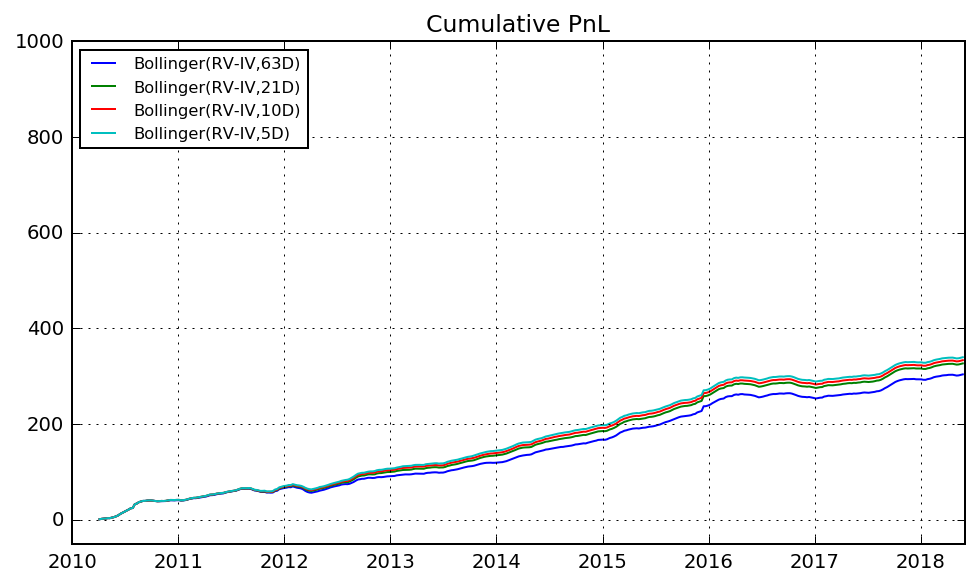

In [33]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Bollinger(RV-IV,63D)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Bollinger(RV-IV,21D)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='Bollinger(RV-IV,10D)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='Bollinger(RV-IV,5D)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [34]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['Bollinger(RV-IV,63D)','Bollinger(RV-IV,21D)','Bollinger(RV-IV,10D)','Bollinger(RV-IV,5D)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"Bollinger(RV-IV,63D)",1.32069,0.739241,1.11948,0.800487,-2.96283,0.18839,0.718067,1.21267,9.86027
"Bollinger(RV-IV,21D)",1.41255,0.794962,1.12557,0.810219,-2.65078,0.227151,0.760436,1.29189,9.85089
"Bollinger(RV-IV,10D)",1.44594,0.811335,1.12222,0.822384,-2.29783,0.256213,0.781664,1.29189,9.85089
"Bollinger(RV-IV,5D)",1.47285,0.826424,1.12221,0.829684,-2.29783,0.262694,0.811645,1.30229,9.85089


In [35]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['Bollinger(RV-IV,63D)','Bollinger(RV-IV,21D)','Bollinger(RV-IV,10D)','Bollinger(RV-IV,5D)'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
"Bollinger(RV-IV,63D)",1.07124,0.495087,0.497436,0.563046,0.962918,1.40185,0.320789,0.77636
"Bollinger(RV-IV,21D)",1.08411,0.524392,0.636658,0.687989,1.01576,1.46699,0.337684,0.789654
"Bollinger(RV-IV,10D)",1.08953,0.539365,0.692497,0.71223,1.05191,1.46019,0.354625,0.774441
"Bollinger(RV-IV,5D)",1.09176,0.562534,0.731607,0.745336,1.06711,1.46637,0.359801,0.774804


## Vol Skew

In [36]:
pnl1 = backtest3m((stock_iv1m75delta - stock_iv1m25delta))
pnl2 = backtest3m((stock_iv1m75delta - stock_iv1m25delta) / stock_iv1m50delta)
pnl3 = backtest3m((stock_iv2m75delta - stock_iv2m25delta))
pnl4 = backtest3m((stock_iv2m75delta - stock_iv2m25delta) / stock_iv1m50delta)

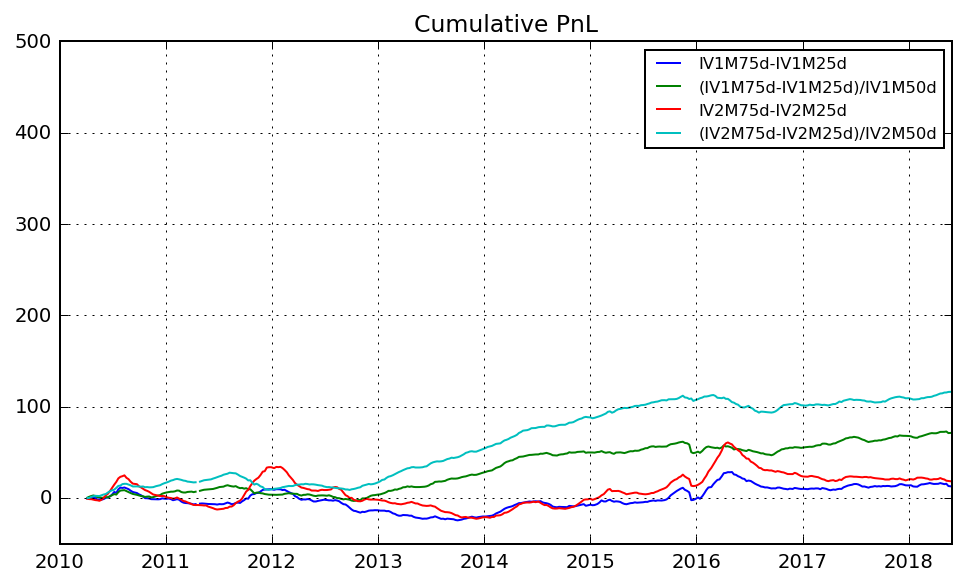

In [37]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV1M75d-IV1M25d')
plt.plot(pnl2[pnl2!=0].cumsum(), label='(IV1M75d-IV1M25d)/IV1M50d')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV2M75d-IV2M25d')
plt.plot(pnl4[pnl4!=0].cumsum(), label='(IV2M75d-IV2M25d)/IV2M50d')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper right', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [38]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV1M75d-IV1M25d','(IV1M75d-IV1M25d)/IV1M50d','IV2M75d-IV2M25d','(IV2M75d-IV2M25d)/IV2M50d'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
IV1M75d-IV1M25d,0.0575132,0.0320816,1.11563,0.496241,-8.58094,-0.569039,-0.0113872,0.58977,3.84838
(IV1M75d-IV1M25d)/IV1M50d,0.407689,0.178888,0.877569,0.631579,-8.36783,-0.303219,0.235803,0.690463,2.6924
IV2M75d-IV2M25d,0.0615976,0.0445159,1.44538,0.452555,-7.35303,-0.767837,-0.115325,0.700808,5.32238
(IV2M75d-IV2M25d)/IV2M50d,0.697945,0.292008,0.836765,0.676692,-2.71444,-0.188965,0.383358,0.891105,2.1415


In [39]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['IV1M75d-IV1M25d','(IV1M75d-IV1M25d)/IV1M50d','IV2M75d-IV2M25d','(IV2M75d-IV2M25d)/IV2M50d'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
IV1M75d-IV1M25d,-0.0228594,0.218567,-0.491914,-0.142488,0.265548,0.136878,0.218514,0.0801187
(IV1M75d-IV1M25d)/IV1M50d,0.147022,-0.0389524,0.00172627,0.498943,0.483516,-0.0038409,0.10355,0.263571
IV2M75d-IV2M25d,0.0506094,0.62275,-0.713548,-0.386337,0.395563,0.290974,0.214689,-0.0961202
(IV2M75d-IV2M25d)/IV2M50d,0.438204,-0.142994,0.161643,0.760925,0.759389,0.371255,-0.115876,0.152554


## Term Structure

In [40]:
pnl1 = backtest3m(- stock_iv3m + stock_iv12m)
pnl2 = backtest3m(- stock_iv6m + stock_iv12m)
pnl3 = backtest3m(- stock_iv3m + stock_iv6m)
pnl4 = backtest3m(- stock_iv1m + stock_iv3m)
pnl5 = backtest3m(- stock_iv2m + stock_iv3m)

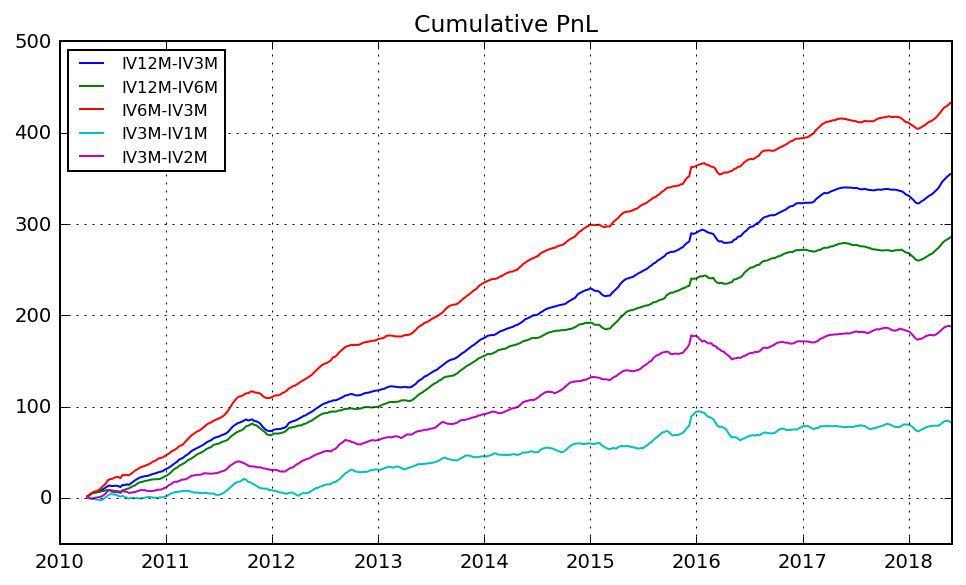

In [41]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-IV6M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV6M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV3M-IV1M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='IV3M-IV2M')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [42]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['IV12M-IV3M','IV12M-IV6M','IV6M-IV3M','IV3M-IV1M','IV3M-IV2M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
IV12M-IV3M,1.49175,0.863035,1.15708,0.819951,-3.41959,0.321141,1.03108,1.54444,9.12692
IV12M-IV6M,1.33097,0.694398,1.04345,0.79562,-3.81298,0.170341,0.742377,1.3117,8.01459
IV6M-IV3M,1.80957,1.0528,1.16359,0.854015,-3.98255,0.454937,1.14841,1.69607,10.2041
IV3M-IV1M,0.337906,0.20174,1.19406,0.579075,-3.62076,-0.502363,0.19312,0.826225,10.7618
IV3M-IV2M,0.805164,0.457419,1.13621,0.698297,-2.90902,-0.196131,0.504811,1.07584,10.2942


In [43]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['IV3M-IV12M','IV6M-IV12M','IV1M-IV3M','IV1M-IV12M','IV1M-IV2M'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
IV3M-IV12M,0.807833,0.835144,0.888281,1.13424,1.07217,1.21689,0.653269,0.193369
IV6M-IV12M,0.61912,0.884786,0.62188,1.10388,0.732294,0.954144,0.62986,-0.0551431
IV1M-IV3M,1.20253,1.26147,1.27323,1.22378,1.25134,1.29064,0.614609,0.358072
IV1M-IV12M,0.0338874,0.140225,0.453151,0.290083,0.285514,0.667913,-0.334716,0.0658019
IV1M-IV2M,0.286922,0.388976,0.650153,0.566805,0.780184,0.919452,-0.122132,0.240927


## IV Momentum

In [44]:
pnl1 = backtest3m(-(stock_iv3m - stock_iv3m.shift(63)) / stock_iv3m.shift(63))
pnl2 = backtest3m(-(stock_iv3m - stock_iv3m.shift(21)) / stock_iv3m.shift(21))
pnl3 = backtest3m(-(stock_iv3m - stock_iv3m.shift(10)) / stock_iv3m.shift(10))
pnl4 = backtest3m(-(stock_iv3m - stock_iv3m.shift(5)) / stock_iv3m.shift(5))

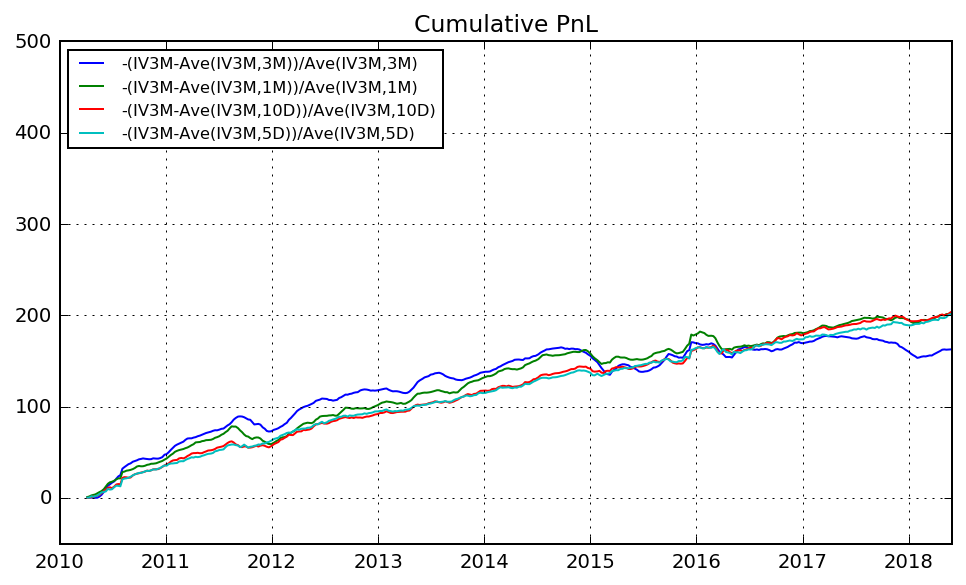

In [45]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [46]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)','-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)','-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)', '-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)",0.57553,0.39578,1.37536,0.63017,-3.31588,-0.353952,0.407062,1.111,8.73465
"-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)",0.784386,0.492483,1.25572,0.712895,-4.51744,-0.1105,0.562989,1.12188,10.0975
"-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)",0.895917,0.494374,1.10362,0.729927,-4.50519,-0.107346,0.539578,1.01342,7.80679
"-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)",0.899358,0.489215,1.08792,0.712895,-3.36731,-0.0803835,0.490883,1.03402,9.3974


In [47]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)','-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)','-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)', '-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
"-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)",1.24638,0.502788,0.897982,0.392848,0.396726,0.238328,0.00219227,-0.149852
"-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)",1.10542,0.332341,0.85379,0.594155,0.586719,0.358648,0.0419724,0.299396
"-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)",0.937893,0.412587,0.704032,0.511995,0.497982,0.401819,0.302845,0.357635
"-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)",0.938396,0.530207,0.642021,0.400179,0.469182,0.505278,0.193702,0.315394


## IV Mean Reverse

In [48]:
pnl1 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 63) / pd.rolling_mean(stock_iv3m, 63)))
pnl2 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 21) / pd.rolling_mean(stock_iv3m, 21)))
pnl3 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 10) / pd.rolling_mean(stock_iv3m, 10)))
pnl4 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 5) / pd.rolling_mean(stock_iv3m, 5)))

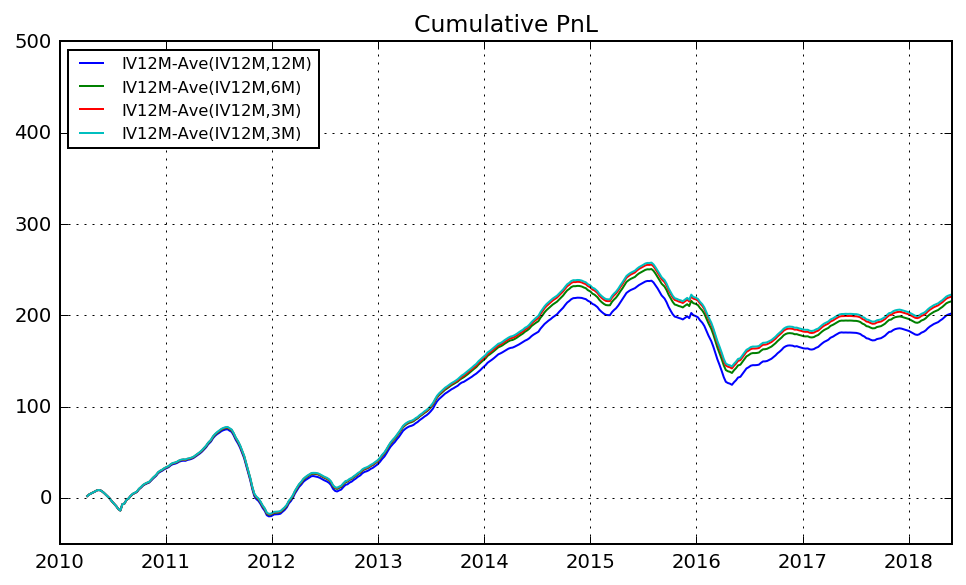

In [49]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-Ave(IV12M,12M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-Ave(IV12M,6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [50]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)', '123'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"IV12M-Ave(IV12M,12M)",0.410283,0.490642,2.39172,0.70073,-9.60898,-0.57015,1.18109,1.88986,6.96288
"IV12M-Ave(IV12M,6M)",0.432646,0.523134,2.4183,0.70073,-9.60898,-0.51587,1.21282,1.96519,6.96288
"IV12M-Ave(IV12M,3M)",0.441306,0.535587,2.42728,0.703163,-9.60898,-0.490406,1.23101,1.9956,6.96288
123,0.445589,0.541039,2.42842,0.70073,-9.60898,-0.515596,1.23101,2.02,6.96288


In [51]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
"IV12M-Ave(IV12M,12M)",0.83084,-1.00994,1.13788,2.11298,1.46769,-0.328448,-0.69103,0.385871
"IV12M-Ave(IV12M,6M)",0.851117,-0.991078,1.16555,2.20154,1.54927,-0.295395,-0.691339,0.379656
"IV12M-Ave(IV12M,3M)",0.857654,-0.985136,1.16678,2.22798,1.60047,-0.285398,-0.69056,0.381139


## RV Momentum

In [52]:
pnl1 = backtest3m((stock_rv3m - stock_rv3m.shift(63)) )
pnl2 = backtest3m((stock_rv3m - stock_rv3m.shift(21)))
pnl3 = backtest3m((stock_rv3m - stock_rv3m.shift(10)))
pnl4 = backtest3m((stock_rv3m - stock_rv3m.shift(5)))

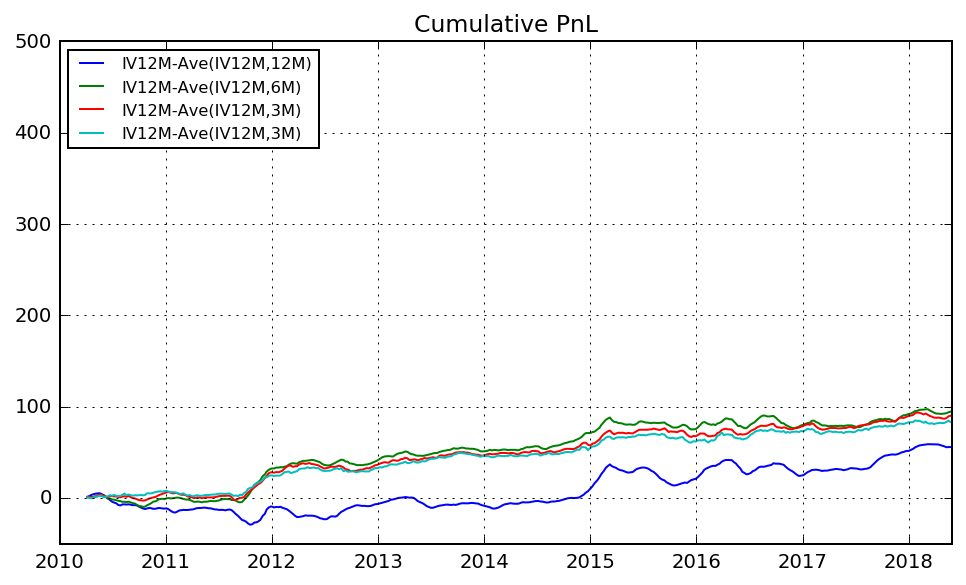

In [53]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-Ave(IV12M,12M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-Ave(IV12M,6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [54]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)', '123'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"IV12M-Ave(IV12M,12M)",0.232807,0.135602,1.16492,0.576642,-3.6847,-0.49812,0.193884,0.700029,5.0346
"IV12M-Ave(IV12M,6M)",0.429797,0.229731,1.06902,0.593674,-2.91805,-0.397748,0.200102,0.800769,4.31057
"IV12M-Ave(IV12M,3M)",0.437643,0.219124,1.00138,0.586375,-2.87835,-0.382973,0.248005,0.833519,3.17356
123,0.403897,0.202744,1.00394,0.596107,-3.14287,-0.414059,0.213308,0.850876,3.89478


In [55]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
"IV12M-Ave(IV12M,12M)",-0.307218,0.0478328,0.052531,-0.0310415,0.308231,0.269229,0.0690446,0.536719
"IV12M-Ave(IV12M,6M)",-0.0312047,0.654045,0.182542,0.193586,0.401426,0.0839739,0.0813471,0.227694
"IV12M-Ave(IV12M,3M)",0.138885,0.448543,0.1656,0.196029,0.242358,0.18175,0.209186,0.20898


## RV - IV Trend Following?

In [56]:
stock_rviv = stock_rv3m - stock_iv3m

pnl1 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 63) / pd.rolling_mean(stock_rviv, 63)))
pnl2 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 21) / pd.rolling_mean(stock_rviv, 21)))
pnl3 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 10) / pd.rolling_mean(stock_rviv, 10)))
pnl4 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 5) / pd.rolling_mean(stock_rviv, 5)))

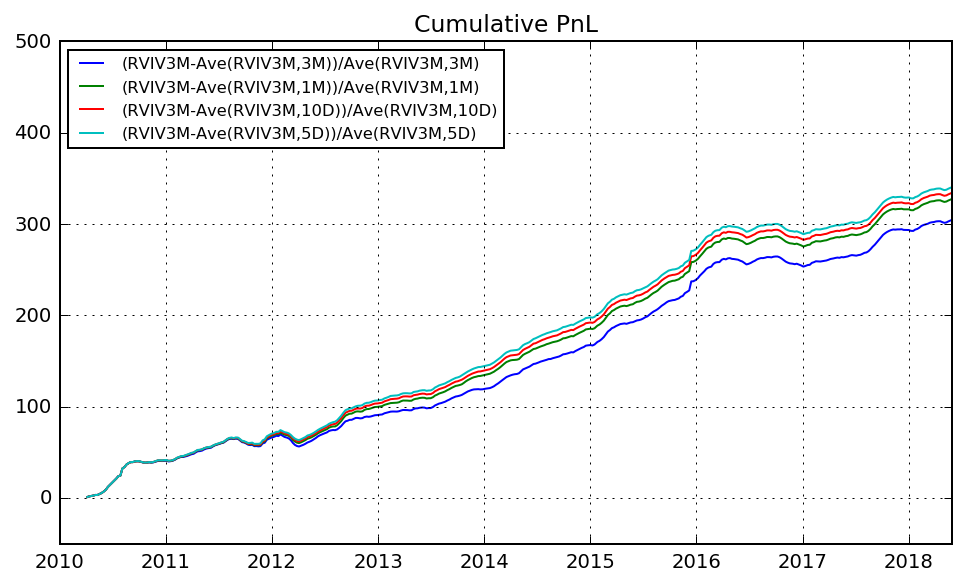

In [57]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='(RVIV3M-Ave(RVIV3M,3M))/Ave(RVIV3M,3M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='(RVIV3M-Ave(RVIV3M,1M))/Ave(RVIV3M,1M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='(RVIV3M-Ave(RVIV3M,10D))/Ave(RVIV3M,10D)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='(RVIV3M-Ave(RVIV3M,5D))/Ave(RVIV3M,5D)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [58]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['(RVIV3M-Ave(RVIV3M,3M))/Ave(RVIV3M,3M)','(RVIV3M-Ave(RVIV3M,1M))/Ave(RVIV3M,1M)','(RVIV3M-Ave(RVIV3M,10D))/Ave(RVIV3M,10D)', '(RVIV3M-Ave(RVIV3M,5D))/Ave(RVIV3M,5D)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"(RVIV3M-Ave(RVIV3M,3M))/Ave(RVIV3M,3M)",1.32069,0.739241,1.11948,0.800487,-2.96283,0.18839,0.718067,1.21267,9.86027
"(RVIV3M-Ave(RVIV3M,1M))/Ave(RVIV3M,1M)",1.41255,0.794962,1.12557,0.810219,-2.65078,0.227151,0.760436,1.29189,9.85089
"(RVIV3M-Ave(RVIV3M,10D))/Ave(RVIV3M,10D)",1.44594,0.811335,1.12222,0.822384,-2.29783,0.256213,0.781664,1.29189,9.85089
"(RVIV3M-Ave(RVIV3M,5D))/Ave(RVIV3M,5D)",1.47285,0.826424,1.12221,0.829684,-2.29783,0.262694,0.811645,1.30229,9.85089


In [59]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['(RVIV3M-Ave(RVIV3M,3M))/Ave(RVIV3M,3M)','(RVIV3M-Ave(RVIV3M,1M))/Ave(RVIV3M,1M)','(RVIV3M-Ave(RVIV3M,10D))/Ave(RVIV3M,10D)', '(RVIV3M-Ave(RVIV3M,5D))/Ave(RVIV3M,5D)'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
"(RVIV3M-Ave(RVIV3M,3M))/Ave(RVIV3M,3M)",1.07124,0.495087,0.497436,0.563046,0.962918,1.40185,0.320789,0.77636
"(RVIV3M-Ave(RVIV3M,1M))/Ave(RVIV3M,1M)",1.08411,0.524392,0.636658,0.687989,1.01576,1.46699,0.337684,0.789654
"(RVIV3M-Ave(RVIV3M,10D))/Ave(RVIV3M,10D)",1.08953,0.539365,0.692497,0.71223,1.05191,1.46019,0.354625,0.774441
"(RVIV3M-Ave(RVIV3M,5D))/Ave(RVIV3M,5D)",1.09176,0.562534,0.731607,0.745336,1.06711,1.46637,0.359801,0.774804


## RV-IV Momentum

In [60]:
stock_rviv = stock_rv3m - stock_iv3m
pnl1 = backtest3m((stock_rviv - stock_rviv.shift(5)))
pnl2 = backtest3m((stock_rviv - stock_rviv.shift(10)))
pnl3 = backtest3m((stock_rviv - stock_rviv.shift(21)))
pnl4 = backtest3m((stock_rviv - stock_rviv.shift(63)))

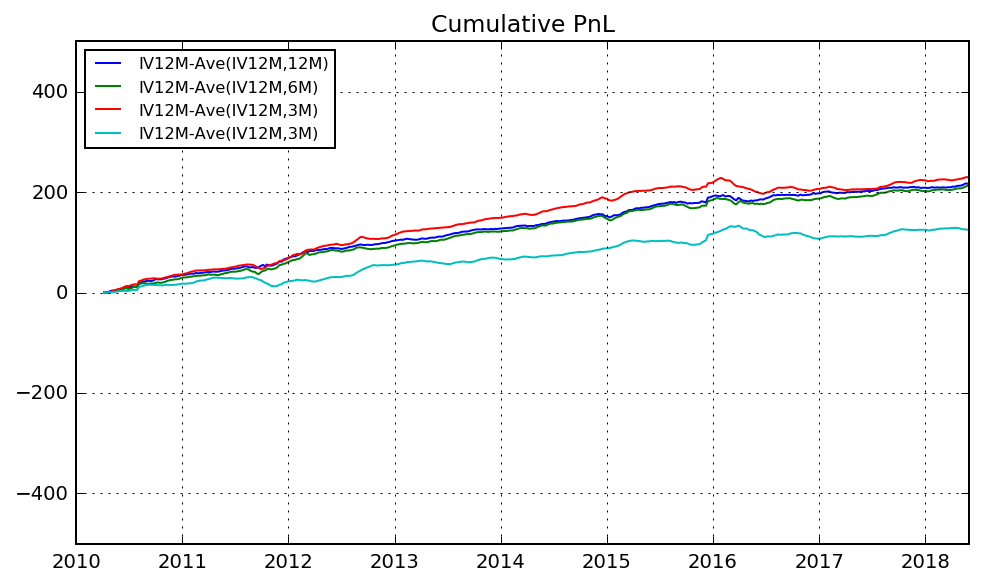

In [61]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-Ave(IV12M,12M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-Ave(IV12M,6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [62]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)', '123'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"IV12M-Ave(IV12M,12M)",0.84369,0.527374,1.25016,0.698297,-3.27246,-0.147738,0.499643,1.16225,10.1278
"IV12M-Ave(IV12M,6M)",0.806366,0.516769,1.28172,0.710462,-4.09056,-0.11064,0.559343,1.10804,8.9379
"IV12M-Ave(IV12M,3M)",0.894321,0.558647,1.24932,0.746959,-4.09319,-0.0189862,0.52435,1.18989,7.33714
123,0.523995,0.304478,1.16214,0.639903,-4.54659,-0.251506,0.292192,0.892928,10.4439


In [ ]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)'])
pnl_mean_yearly

,2010,2011,2012,2013,2014,2015,2016,2017
"IV12M-Ave(IV12M,12M)",0.913647,0.662919,0.692544,0.480675,0.509167,0.7629,0.121207,0.218971
"IV12M-Ave(IV12M,6M)",0.757844,0.619289,0.665212,0.549162,0.562574,0.687143,0.0528225,0.297957
"IV12M-Ave(IV12M,3M)",0.938143,0.625754,0.948567,0.6712,0.783059,0.604797,-0.248821,0.352295


## RV Momentum

In [ ]:
#stock_rviv = stock_rv3m - stock_iv3m
stock_rviv = stock_rv3m
pnl1 = backtest3m((stock_rv3m - stock_rv3m.shift(10)) / stock_rv3m.shift(10))
pnl2 = backtest3m((stock_rv3m - stock_rv3m.shift(21)) / stock_rv3m.shift(21))
pnl3 = backtest3m((stock_rv3m - stock_rv3m.shift(63)) / stock_rv3m.shift(63))
pnl4 = backtest3m((stock_rv3m - stock_rv3m.shift(126)) / stock_rv3m.shift(126))

In [ ]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV12M-Delay(RV12M,6M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV12M-Delay(RV12M,3M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV12M-Delay(RV12M,1M)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [ ]:
performance = report_table([pnl1,pnl2,pnl3], ['RV12M-Delay(RV12M,6M)','RV12M-Delay(RV12M,3M)','RV12M-Delay(RV12M,1M)'])
performance

In [ ]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['RV12M-Delay(RV12M,6M)','RV12M-Delay(RV12M,3M)','RV12M-Delay(RV12M,1M)'])
pnl_mean_yearly

## Cash Bollinger

In [ ]:
pnl1 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 63)) / pd.rolling_std(stock_prices, 63)))
pnl2 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 126)) / pd.rolling_std(stock_prices, 126)))
pnl3 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 252)) / pd.rolling_std(stock_prices, 252)))
pnl4 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 378)) / pd.rolling_std(stock_prices, 378)))

In [ ]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Bollinger(3M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Bollinger(6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='Bollinger(12M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='Bollinger(18M)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [ ]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['Bollinger(3M)','Bollinger(6M)','Bollinger(12M)','Bollinger(18M)'])
performance

In [ ]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['Bollinger(3M)','Bollinger(6M)','Bollinger(12M)','Bollinger(18M)'])
pnl_mean_yearly

## Cash RSI

In [ ]:
stock_delta1 = stock_prices - stock_prices.shift(1)
stock_gain = stock_delta1[stock_delta1>0]
stock_loss = np.abs(stock_delta1[stock_delta1<0])

def stock_rsi(N):
    return 100 * 1 / (1 + pd.rolling_mean(stock_loss, N, min_periods=0) / pd.rolling_mean(stock_gain, N, min_periods=0))

In [ ]:
pnl1 = backtest3m(-stock_rsi(21))
pnl2 = backtest3m(-stock_rsi(63))
pnl3 = backtest3m(-stock_rsi(126))
pnl4 = backtest3m(-stock_rsi(252))

In [ ]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='-RSI(1M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='-RSI(3M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='-RSI(6M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='-RSI(12M)')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [ ]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['-RSI(1M)','-RSI(3M)','-RSI(6M)','-RSI(12M)'])
performance

In [ ]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['-RSI(1M)','-RSI(3M)','-RSI(6M)','-RSI(12M)'])
pnl_mean_yearly

## Fundamentals

In [ ]:
pnl1 = backtest3m(stock_asset_per_equity)
pnl2 = backtest3m(stock_asset_per_marketcap)
pnl3 = backtest3m(-stock_eps)
pnl4 = backtest3m(-stock_roe)
pnl5 = backtest3m(stock_cps)
pnl6 = backtest3m(stock_cpx_per_marketcap)
pnl7 = backtest3m(stock_dps)

In [ ]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Asset/Equity')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Asset/MC')
plt.plot(pnl3[pnl3!=0].cumsum(), label='-EPS')
plt.plot(pnl4[pnl4!=0].cumsum(), label='-ROE')
plt.plot(pnl5[pnl5!=0].cumsum(), label='CPS')
plt.plot(pnl6[pnl6!=0].cumsum(), label='CPX/MC')
plt.plot(pnl7[pnl7!=0].cumsum(), label='DPS')
plt.xlim(pd.to_datetime('20100101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-100, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [ ]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5,pnl6,pnl7], ['Asset/Equity','Asset/MC','-EPS','-ROE','CPS','CPX/MC','DPS'])
performance

In [ ]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5,pnl6,pnl7], ['Asset/Equity','Asset/MC','-EPS','-ROE','CPS','CPX/MC','DPS'])
pnl_mean_yearly